Mount Google Drive

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
train_dir = '/content/drive/MyDrive/disease_skin/train'
test_dir = '/content/drive/MyDrive/disease_skin/test'

In [91]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

In [92]:
# Image size
img_size = (224, 224)

# Training with more augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

In [93]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [94]:
# Train and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

Found 320 images belonging to 5 classes.
Found 80 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [95]:
# Load InceptionV3 with pretrained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the base model (more layers)
for layer in base_model.layers[-80:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [96]:
# Compile the model
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [97]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

# Training
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[LearningRateScheduler(lr_scheduler), early_stopping, reduce_lr]
)

Epoch 1/50
10/10 [==============================] - 41s 1s/step - loss: 10.2579 - accuracy: 0.3625 - val_loss: 9.7604 - val_accuracy: 0.2875 - lr: 1.0000e-04
Epoch 2/50
10/10 [==============================] - 9s 899ms/step - loss: 9.2839 - accuracy: 0.6062 - val_loss: 9.4169 - val_accuracy: 0.4500 - lr: 1.0000e-04
Epoch 3/50
10/10 [==============================] - 11s 1s/step - loss: 8.8771 - accuracy: 0.7375 - val_loss: 9.2810 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 4/50
10/10 [==============================] - 10s 1s/step - loss: 8.7093 - accuracy: 0.7906 - val_loss: 9.1617 - val_accuracy: 0.5750 - lr: 1.0000e-04
Epoch 5/50
10/10 [==============================] - 9s 885ms/step - loss: 8.5593 - accuracy: 0.8344 - val_loss: 8.9918 - val_accuracy: 0.6375 - lr: 1.0000e-04
Epoch 6/50
10/10 [==============================] - 11s 1s/step - loss: 8.5351 - accuracy: 0.8406 - val_loss: 8.9225 - val_accuracy: 0.6625 - lr: 1.0000e-04
Epoch 7/50
10/10 [==============================] - 1

In [98]:
# Evaluation
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

4/4 [==============================] - 1s 187ms/step - loss: 7.9062 - accuracy: 0.8900
Test Accuracy: 89.00%


In [99]:
# Classification Report
import numpy as np
from sklearn.metrics import classification_report

# Predict classes for test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# True classes for test set
true_classes = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Generate classification report
report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

4/4 [==============================] - 2s 223ms/step
                                precision    recall  f1-score   support

               BBC (Sel Basal)       0.10      0.10      0.10        20
             Dermatitis Atopik       0.17      0.20      0.19        20
                Eczema (Eksim)       0.25      0.20      0.22        20
                      Melanoma       0.19      0.20      0.20        20
Tahi Lalat (Nevus Melanositik)       0.11      0.10      0.10        20

                      accuracy                           0.16       100
                     macro avg       0.16      0.16      0.16       100
                  weighted avg       0.16      0.16      0.16       100



4/4 [==============================] - 1s 85ms/step


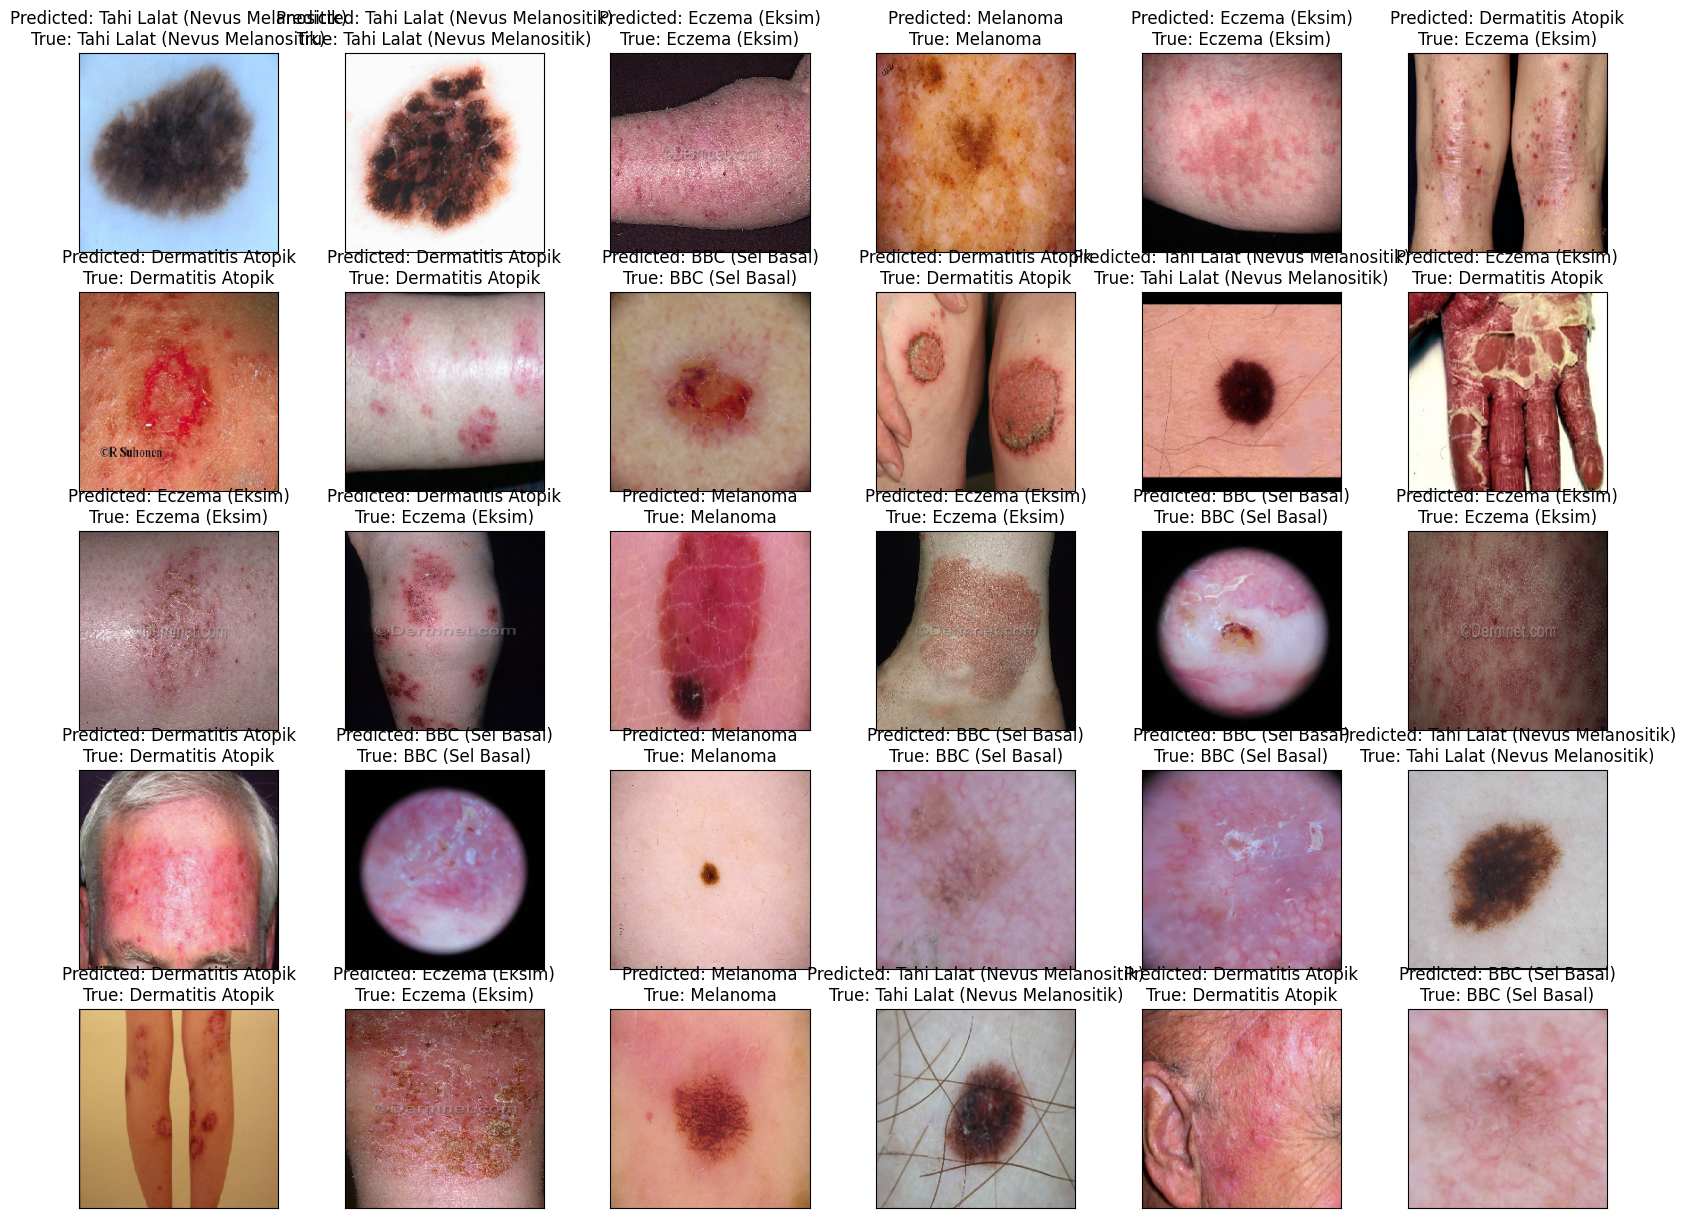

In [100]:
# Get all images and labels from test_generator
test_generator.reset()
X_test, y_test = [], []
for _ in range(len(test_generator)):
    x, y = test_generator.next()
    X_test.extend(x)
    y_test.extend(y)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Predict classes for test set
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

# True classes for test set
true_classes = np.argmax(y_test, axis=1)

# Plot a random sample of test images, their predicted labels, and ground truth
# Number of samples to plot
num_samples = 30

# Get random sample of test indices
random_indices = np.random.choice(len(true_classes), size=num_samples, replace=False)

# Create figure
fig = plt.figure(figsize=(20, 15))  # Adjust the figure size to accommodate more images

for i, idx in enumerate(random_indices):
    ax = fig.add_subplot(5, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[idx])
    pred_label = class_labels[y_pred[idx]]
    true_label = class_labels[true_classes[idx]]
    ax.set_title(f"Predicted: {pred_label}\nTrue: {true_label}")

plt.show()

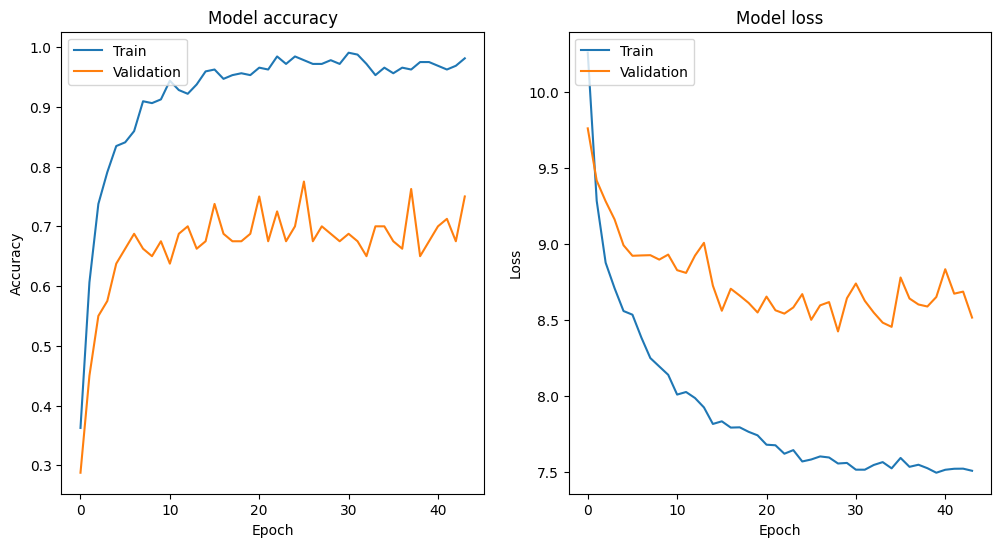

In [101]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [102]:
model.save('DermaOne_Model1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
